<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_QC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is just to get things started. For more in depth analyses that are done in a way more similar to actual research, using the commonly used packages, see the other notebooks further down the list. 

# Setup
We will time how long this thing takes. 

In [0]:
start_time <- Sys.time()

In [2]:
install.packages(c("rsvd", "ggpointdensity"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(Matrix)
library(rsvd)
library(ggplot2) # Tidyverse is pre-installed, yay!
library(dplyr)
library(tidyr)
library(ggpointdensity)
theme_set(theme_bw())


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [0]:
system("pip3 install kb-python")

In [5]:
system("which kb", intern = TRUE)

[1] "/usr/local/bin/kb"

In [0]:
download.file("https://caltech.box.com/shared/static/82yv415pkbdixhzi55qac1htiaph9ng4.idx",
destfile = "idx.idx")
download.file("https://caltech.box.com/shared/static/cflxji16171skf3syzm8scoxkcvbl97x.txt",
destfile = "t2g.txt")

## Pseudoalignment and counting

In this notebook we pseudoalign 1 million *C. elegans* reads and count UMIs to produce a *cells x genes* matrix. These are located at XXX and instead of being downloaded, are streamed directly to the Google Colab notebook for quantification. 
See [this blog post](https://sinabooeshaghi.com/2019/07/09/fasterq-to-count-matrices-for-single-cell-rna-seq/) for more details on how the streaming works.

The data consists of a subset of reads from [GSE126954](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126954) described in the paper:

* Packer, J., Zhu, Q. et al. [A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution](https://science.sciencemag.org/content/365/6459/eaax1971/tab-e-letters). Science (2019). doi:10.1126/science.aax1971

In [7]:
system("kb count -i idx.idx -g t2g.txt --overwrite -t 2 -x 10xv2 https://caltech.box.com/shared/static/fh81mkceb8ydwma3tlrqfgq22z4kc4nt.gz https://caltech.box.com/shared/static/ycxkluj5my7g3wiwhyq3vhv71mw5gmj5.gz",
intern = TRUE)

character(0)

# QC

In [0]:
mat <- readMM("/content/counts_unfiltered/cells_x_genes.mtx")

In [0]:
# Convert to dgCMatrix
mat <- as(mat, "dgCMatrix")

In [10]:
dim(mat)

[1] 95372 22113

Here cells are in rows and genes are in columns, while usually in single cell analyses, cells are in columns and genes are in rows. Here most "cells" are empty droplets.

## Remove empty droplets

A common way to remove empty droplets is to find the inflection point on the knee plot.

In [0]:
tot_counts <- rowSums(mat)
df <- tibble(total = tot_counts,
             rank = row_number(desc(total))) %>%
      distinct() %>%
      arrange(rank)

Warning message:
“Transformation introduced infinite values in continuous x-axis”


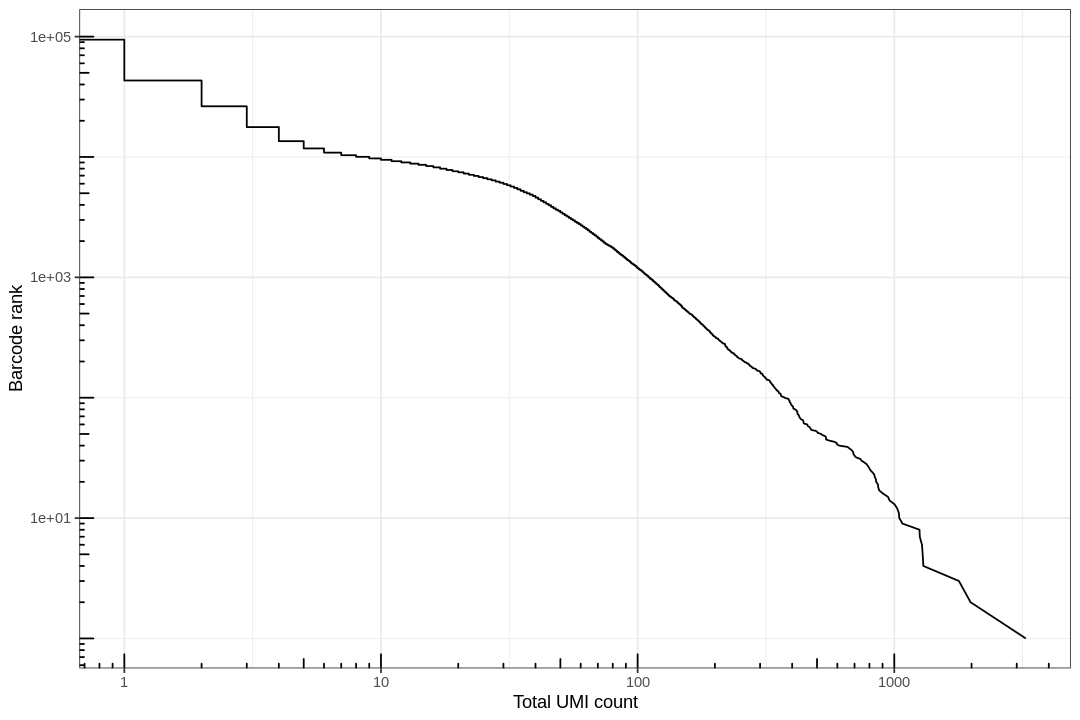

In [12]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(df, aes(total, rank)) +
  geom_path() +
  scale_x_log10() + scale_y_log10() + annotation_logticks() +
  labs(y = "Barcode rank", x = "Total UMI count")

Crappy data, can't see clear inflection point, well, but this is only a subset of the reads. Probably a threshold of at least 30 UMI would work here.

In [13]:
mat <- mat[rowSums(mat) > 30, colSums(mat) > 0] # Also remove 0 count genes
dim(mat)

[1]  5965 11438

In [0]:
df2 <- tibble(nCount = rowSums(mat),
              nGene = rowSums(mat > 0))

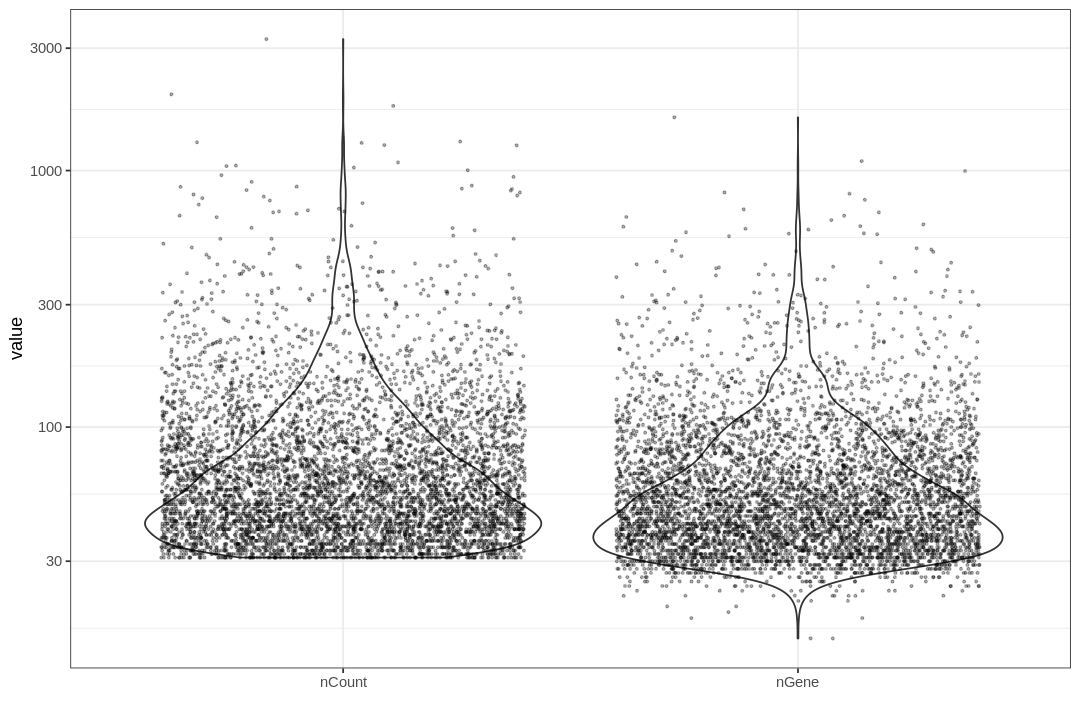

In [15]:
df2 %>%
  pivot_longer(everything()) %>%
  ggplot(aes(name, value)) +
  geom_violin() +
  geom_jitter(size = 0.5, alpha = 0.3) +
  scale_y_log10() +
  labs(x = "")

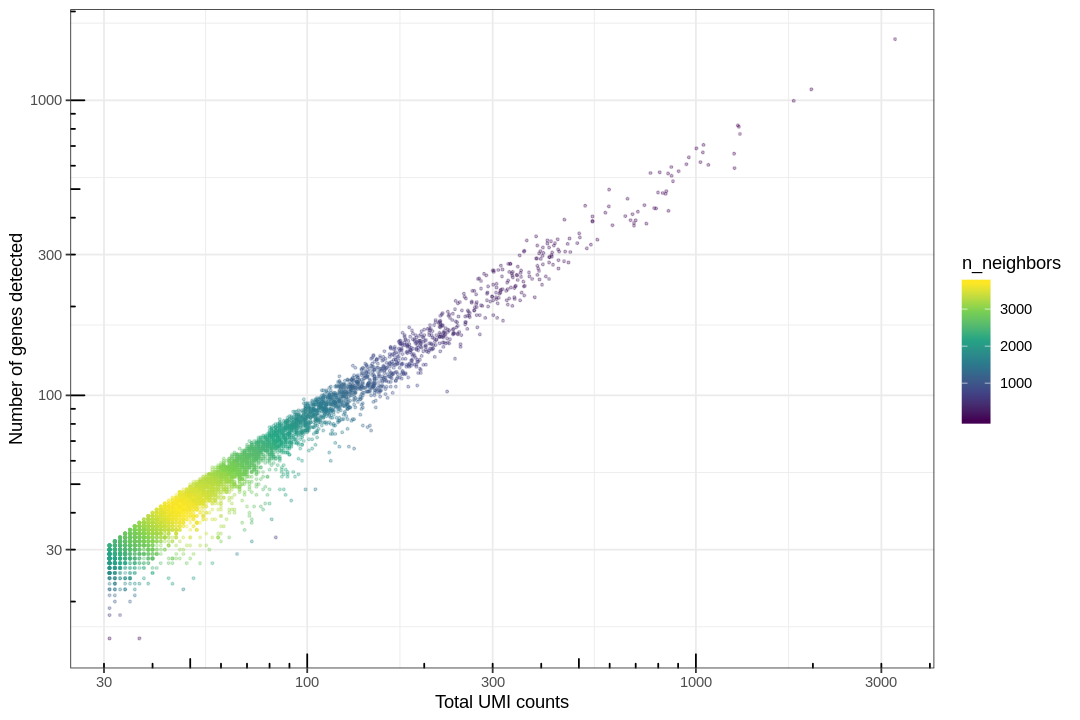

In [16]:
ggplot(df2, aes(nCount, nGene)) +
  geom_pointdensity(size = 0.5, alpha = 0.3) +
  scale_color_viridis_c() +
  scale_x_log10() + scale_y_log10() + annotation_logticks() +
  labs(x = "Total UMI counts", y = "Number of genes detected")

# PCA

In [0]:
# Log normalize, the Seurat way
norm_mat <- log1p(sweep(mat, 1, df2$nCount, FUN = "/") * 1e4)

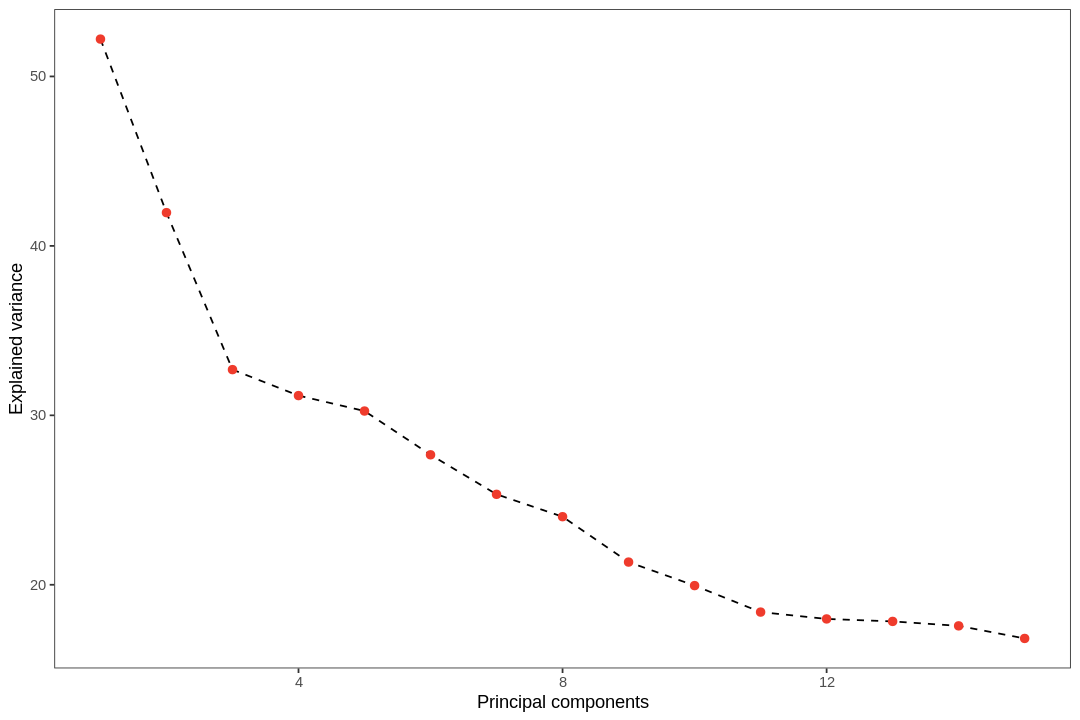

In [18]:
pca_res <- rpca(norm_mat, k = 15) # scales and centers by default
ggscreeplot(pca_res)

In [0]:
colnames(pca_res$x) <- paste0("PC", 1:15)

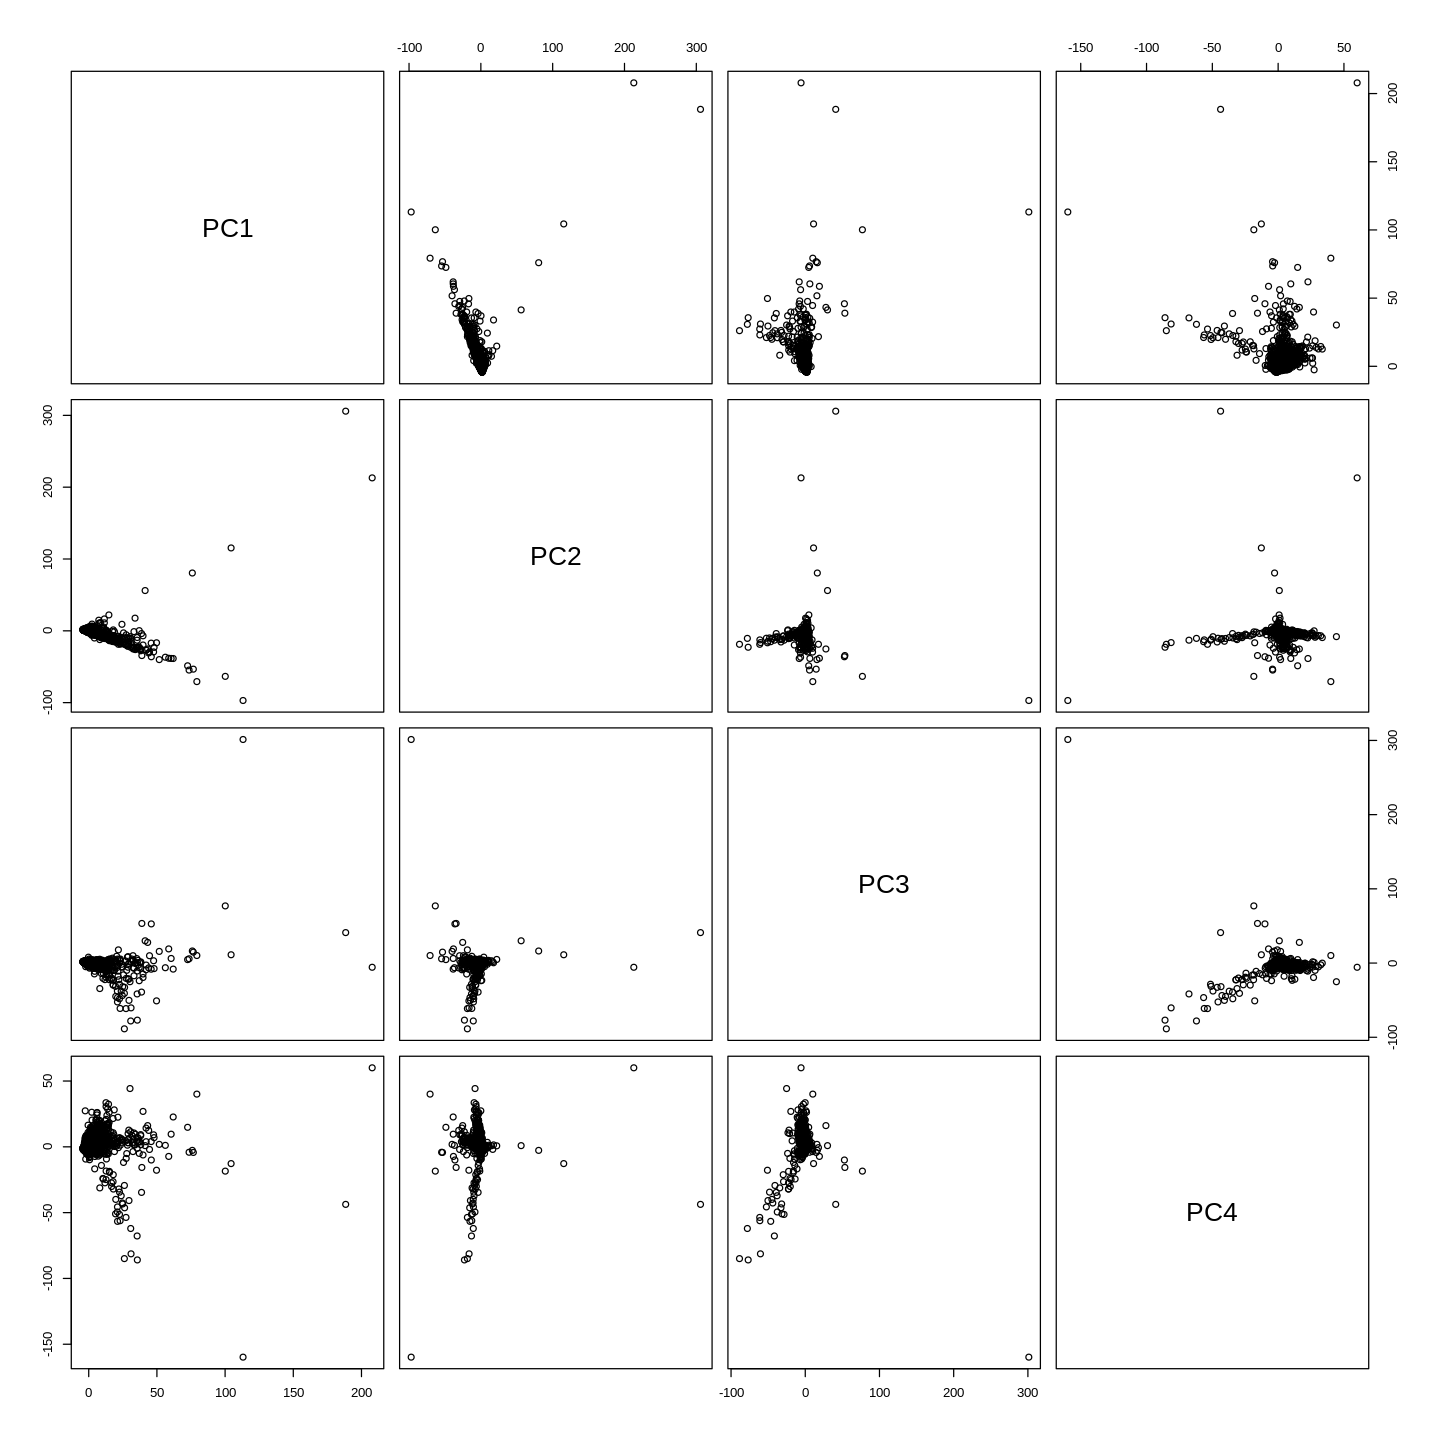

In [20]:
options(repr.plot.width=12, repr.plot.height=12)
pairs(pca_res$x[,1:4])

How long did all this take?

In [21]:
Sys.time() - start_time

Time difference of 2.119382 mins